In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [155]:
import hdbscan
import pprint
import re
import scipy.sparse
import sys
import time
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from helper_functions import *
from fbpca import pca
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

from helper_clustering import get_heuristics_kmeans, get_heuristics_spectral

# Helpers Functions

In [3]:
def load_data(standardized=True, td_idf=True, dim_red=50):

    if td_idf:
        filename = '../data/artist_embeddings/pca/artist_embedding_transformed_pca{}.pickle'.format(
            dim_red)
    else:
        filename = '../data/artist_embeddings/pca/artist_embedding_norm_transformed_pca{}.pickle'.format(
            dim_red)

    X = load_pickle(filename)

    # Standardize the reduced matrix
    if standardized:
        standard_scaler = StandardScaler()
        X = standard_scaler.fit_transform(X)

    artist2id = load_pickle('../data/artist2id.pickle')
    id2artist = load_pickle('../data/id2artist.pickle')

    user2id = load_pickle('../data/user2id.pickle')
    id2user = load_pickle('../data/id2user.pickle')

    return X, artist2id, id2artist, user2id, id2user

In [4]:
def cluster_hdbscan(matrix, min_cluster_size=300, min_samples=30):

    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples)
    hdbscan_model.fit(matrix)

    labels = hdbscan_model.labels_
    centers = hdbscan_model.exemplars_

    return hdbscan_model, labels, centers

In [5]:
def cluster_gmm(matrix, k=8):

    gmm_model = GMM(k, covariance_type='full', random_state=0, n_init=10)
    gmm_model.fit(matrix)

    labels = gmm_model.predict(matrix)
    centers = gmm_model.means_

    return gmm_model, labels, centers

In [22]:
def plot_tune_gmm(ks, scores, standardized=True, td_idf=True, dim_red=50):

    f = plt.figure(figsize=(12, 8))

    plt.plot(ks, scores, label='davies_bouldin_score')
    plt.xticks(ks)

    plt.title('Davies Bouldin score for tuning GMM model', fontsize=24)
    plt.grid()
    plt.legend()

    figname = 'gmm_scores_tdidf{}_dim{}_standardized.pdf'.format(
        td_idf, dim_red, standardized)
    plt.savefig('../data/plots/{}'.format(figname))

    plt.show()

In [23]:
def tune_gmm(X, k_min, k_max, standardized=True, td_idf=True, dim_red=50):

    ks = []
    scores = []

    for k in tqdm(range(k_min, k_max + 1)):
        model, labels, cluster_centers = cluster_gmm(X, k=k)

        score = davies_bouldin_score(X, labels)

        ks.append(k)
        scores.append(score)

    opt_k = ks[np.argmin(scores)]
    print('K that minimizes Davies Bouldin score: {}'.format(opt_k))

    plot_tune_gmm(ks, scores, standardized, td_idf, dim_red)

    return opt_k

In [24]:
def compute_user_means(X, matrix_plays, id2user):

    # Get weight per artist for each user with the normalized number of plays
    matrix_plays_normed = normalize(matrix_plays, norm='l1', axis=1)

    user_means = {}

    for i in tqdm(range(matrix_plays.shape[0])):

        user_row = matrix_plays_normed[i]
        _, artists_idx = user_row.nonzero()

        weights = matrix_plays_normed[i, artists_idx]
        artists_vect = X[artists_idx]

        user_means[id2user[i]] = weights @ artists_vect

    return user_means

In [25]:
def build_matrix_clustering(user_means, artist_model, artist_centers):
    """
    
    """

    ar_users_clusters = np.zeros(
        (len(user_means), artist_centers.shape[0]))

    for i, user in tqdm(enumerate(user_means)):

        user_mean = user_means[user].flatten()

        ar_users_clusters[i] = artist_model.predict_proba([user_mean])

    return ar_users_clusters

In [26]:
def get_2d_projection(ar_users_clusters):

    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=0)
    tsne_results = tsne.fit_transform(ar_users_clusters)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time() -
                                                        time_start))

    return tsne_results

In [45]:
def hdbscan_visualize(ar_users_clusters_scaled,
                      tsne_results,
                      min_cluster_size=50,
                      min_samples=15,
                      standardized=True,
                      td_idf=True,
                      dim_red=50):

    user_model, user_labels, user_cluster_centers = cluster_hdbscan(
        ar_users_clusters_scaled, min_cluster_size, min_samples)

    df_visualization = pd.DataFrame()

    df_visualization["First_dimension"] = tsne_results[:, 0]
    df_visualization["Second_dimension"] = tsne_results[:, 1]
    df_visualization["cluster_labels"] = user_labels

    nb_clusters = len(set(user_labels))

    plt.figure(figsize=(16, 10))
    sns.scatterplot(x="First_dimension",
                    y="Second_dimension",
                    hue="cluster_labels",
                    palette=sns.color_palette("hls", nb_clusters),
                    data=df_visualization,
                    legend="full",
                    alpha=0.3)

    plt.subtitle('HDBSCAN on the users')
    plt.title(
        'Standardized: {}, TD-IDF: {}, Dim. Red.: {}, Min cluster size: {}, Min sample: {}'
        .format(standardized, td_idf, dim_red, min_cluster_size, min_samples))
    plt.show()

    figname = 'hdbscan_user_standardize{}_tdifd{}_dim{}_minClusterSize{}_minSample{}.pfd'.format(
        standardized, td_idf, dim_red, min_cluster_size, min_samples)

    return user_model, user_labels, user_cluster_centers

# Get User-level clustering

## dim = 25, td_idf = true

In [187]:
standardized = True
td_idf = True
dim_red = 25

In [190]:
def user_level_clustering(standardized=True, td_idf=True, dim_red=50):

    # Load data
    print('###Loading data...\n')
    X, artist2id, id2artist, user2id, id2user = load_data(
        standardized, td_idf, dim_red)

    # Compute user vector
    print('###Computing user means vector...\n')
    matrix_plays = scipy.sparse.load_npz('../data/matrix_plays.npz').T
    user_means = compute_user_means(X, matrix_plays, id2user)

    # Get optimal K for artist GMM model
    print('###Tuning artist GMM model...\n')
    opt_k = tune_gmm(X, 10, 25, standardized, td_idf, dim_red)

    # Get artist GMM model
    print('###Computing artist GMM model...\n')
    artist_model, artist_labels, artist_centers = cluster_gmm(X, opt_k)

    # Compute matrix for user clustering
    print('###Computing matrix for clustering...\n')
    ar_users_clusters = build_matrix_clustering(user_means, artist_model,
                                                artist_centers)

    # Get 2D-projection
    print('###Computing 2D-projection...\n')
    tsne_results = get_2d_projection(ar_users_clusters)

    return ar_users_clusters, tsne_results, id2user

###Loading data...

###Computing user means vector...



  0%|          | 0/16 [00:00<?, ?it/s]

###Tuning artist GMM model...



100%|██████████| 16/16 [1:10:08<00:00, 263.03s/it]


K that minimizes Davies Bouldin score: 24


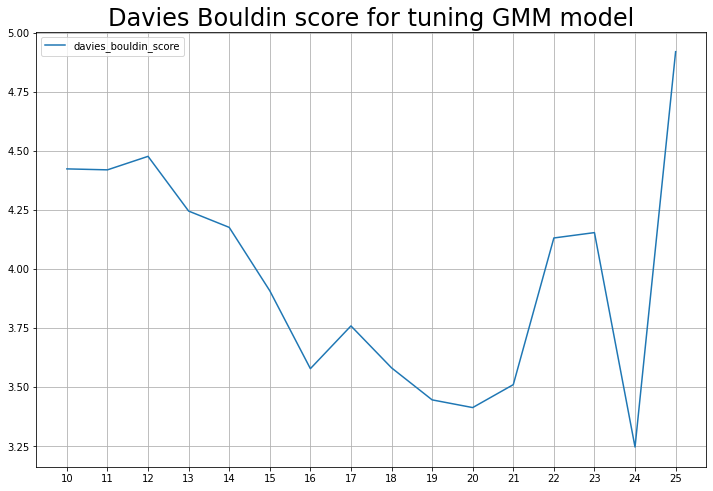

###Computing artist GMM model...



5it [00:00, 37.30it/s]

###Computing matrix for clustering...



94407it [01:25, 1098.44it/s]


###Computing 2D-projection...

t-SNE done! Time elapsed: 1194.5490188598633 seconds


<Figure size 432x288 with 0 Axes>

In [191]:
ar_users_clusters, tsne_results, id2user = user_level_clustering(
    standardized, td_idf, dim_red)

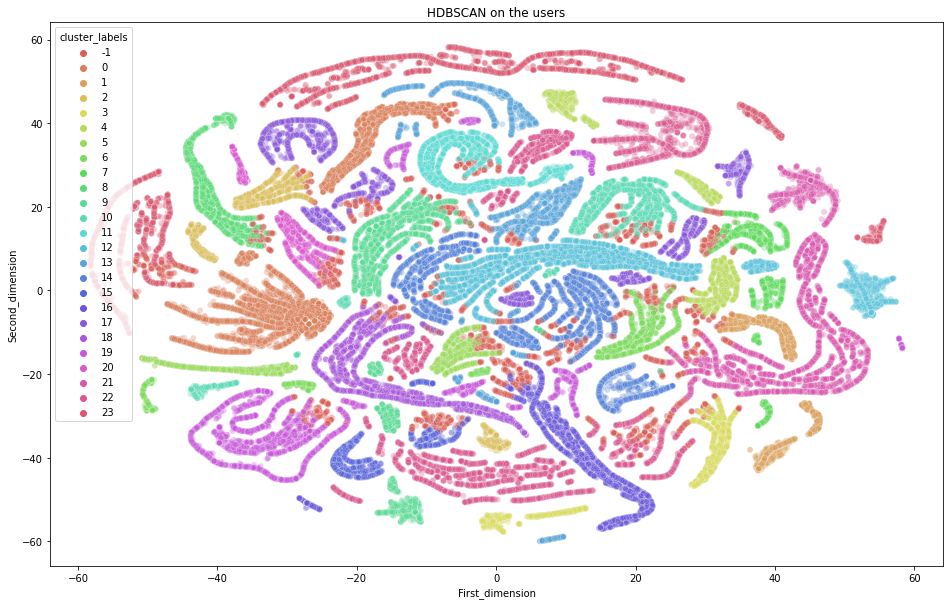

In [192]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters,
                                                          tsne_results,
                                                          min_cluster_size=300,
                                                          min_samples=30)

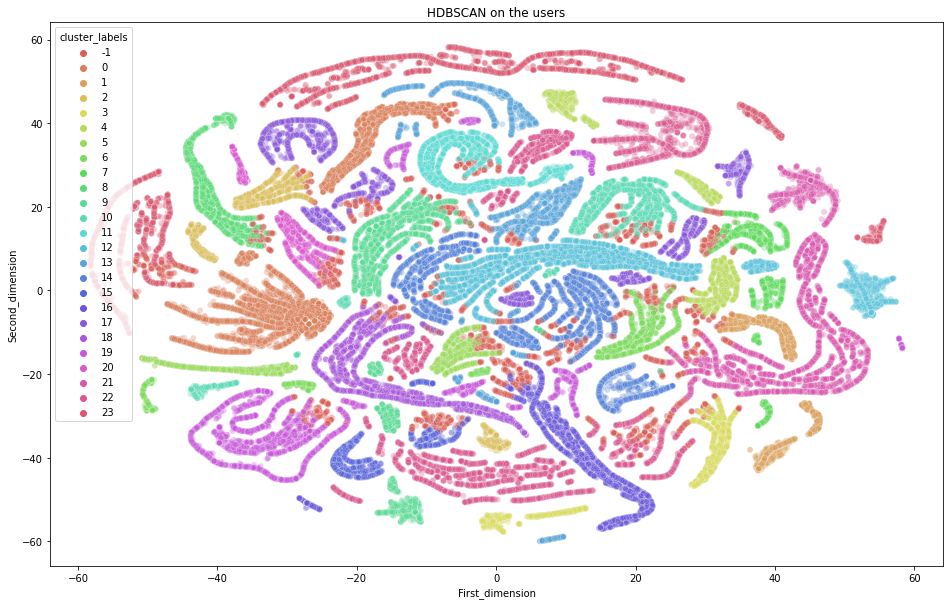

In [193]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters,
                                                          tsne_results,
                                                          min_cluster_size=500,
                                                          min_samples=30)

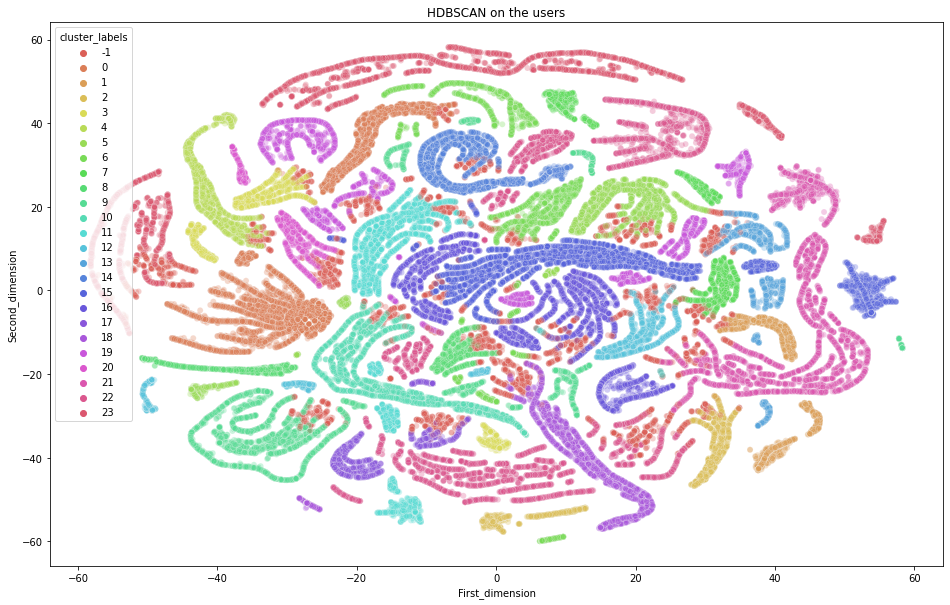

In [194]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters,
                                                          tsne_results,
                                                          min_cluster_size=700,
                                                          min_samples=10)

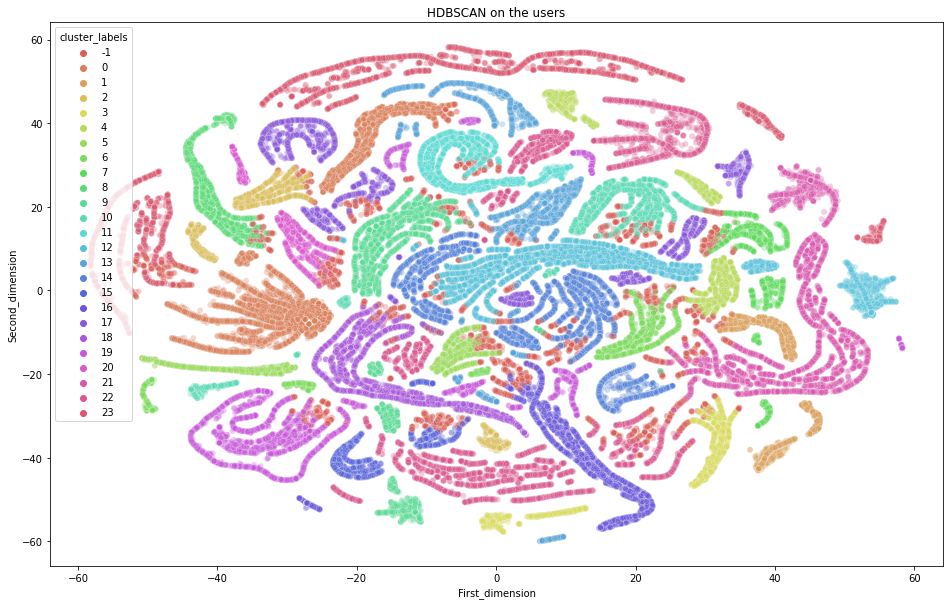

In [195]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters,
                                                          tsne_results,
                                                          min_cluster_size=700,
                                                          min_samples=30)

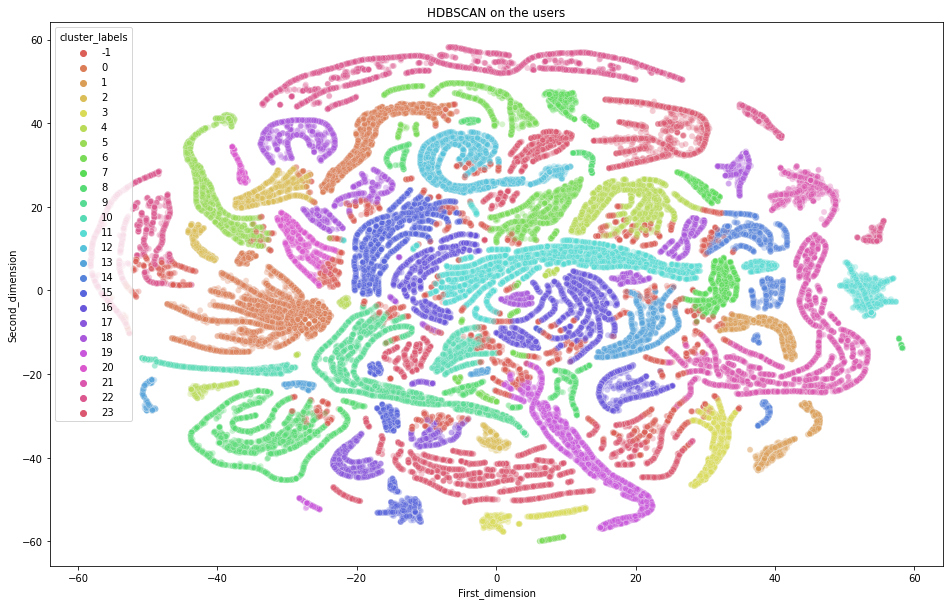

In [196]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters,
                                                          tsne_results,
                                                          min_cluster_size=700,
                                                          min_samples=50)

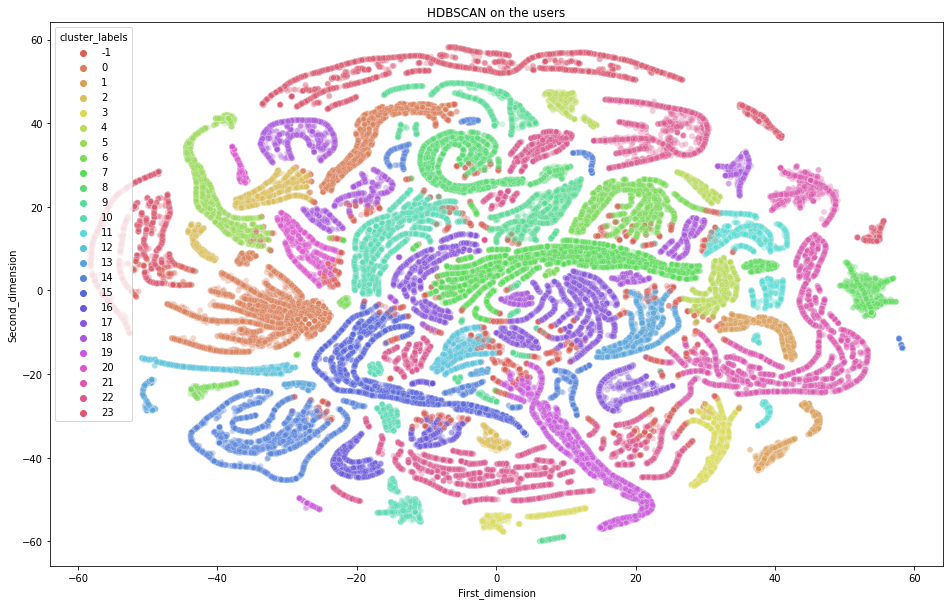

In [197]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters,
                                                          tsne_results,
                                                          min_cluster_size=700,
                                                          min_samples=100)

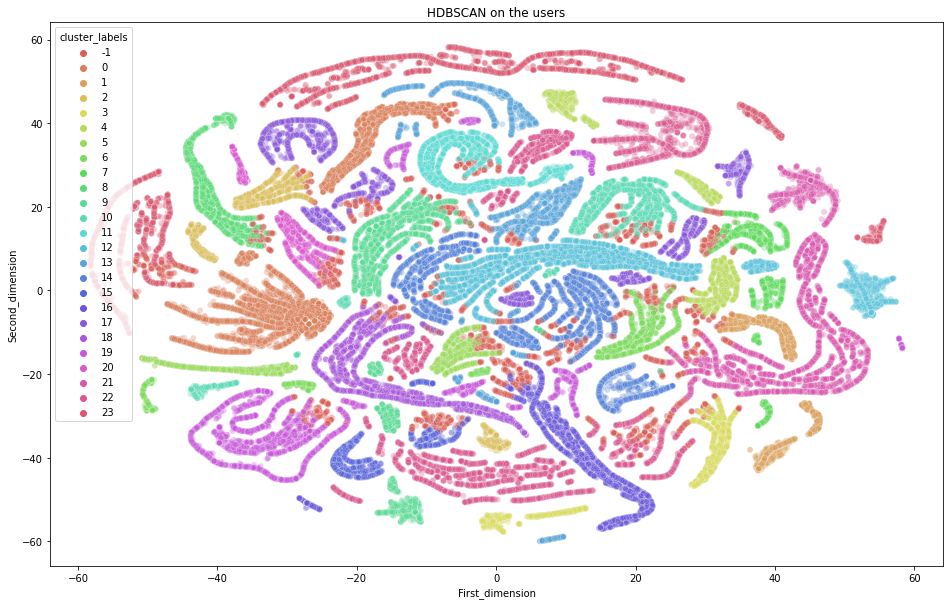

In [198]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters,
                                                          tsne_results,
                                                          min_cluster_size=1000,
                                                          min_samples=30)

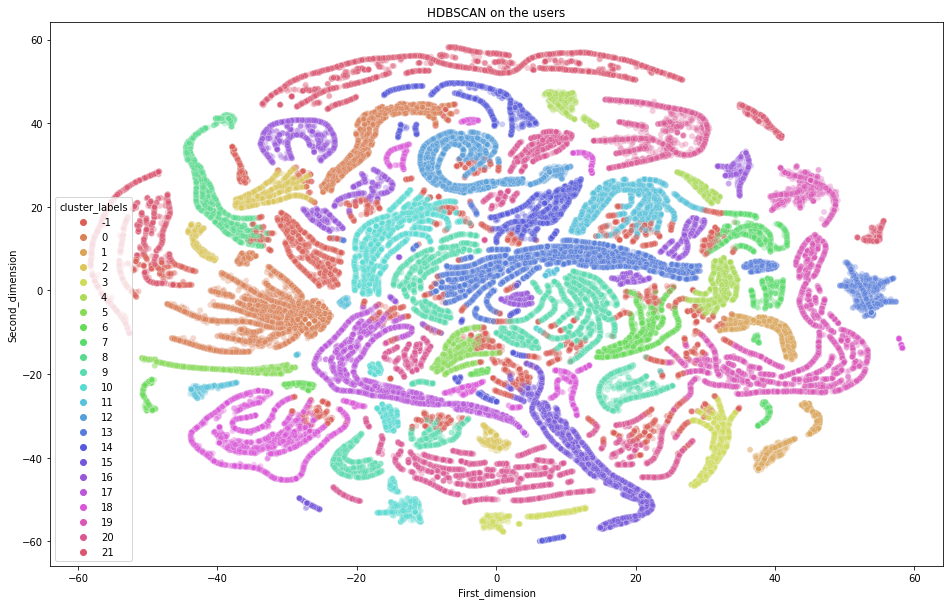

In [212]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters,
                                                          tsne_results,
                                                          min_cluster_size=1500,
                                                          min_samples=30)

## dim = 50, td_idf = true

In [200]:
standardized = True
td_idf = True
dim_red = 50

###Loading data...

###Computing user means vector...



  0%|          | 0/16 [00:00<?, ?it/s]

###Tuning artist GMM model...



100%|██████████| 16/16 [58:34<00:00, 219.66s/it]


K that minimizes Davies Bouldin score: 24


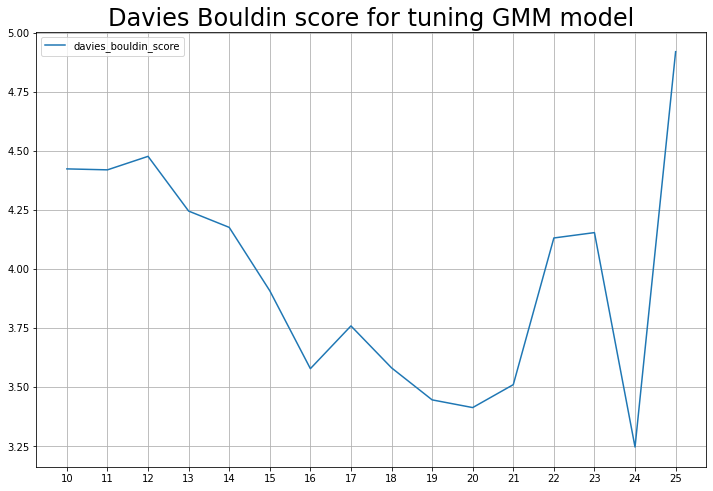

###Computing artist GMM model...



220it [00:00, 939.52it/s]

###Computing matrix for clustering...



94407it [01:00, 1555.35it/s]


###Computing 2D-projection...

t-SNE done! Time elapsed: 1079.6601848602295 seconds


<Figure size 432x288 with 0 Axes>

In [201]:
ar_users_clusters_50, tsne_results_50, id2user_50 = user_level_clustering(
    standardized, td_idf, dim_red)

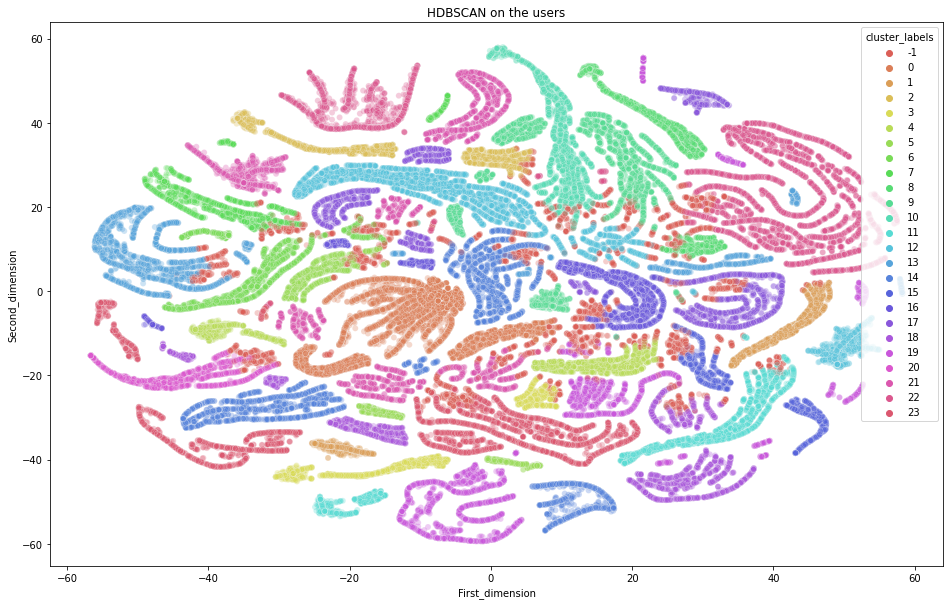

In [202]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters_50,
                                                          tsne_results_50,
                                                          min_cluster_size=300,
                                                          min_samples=30)

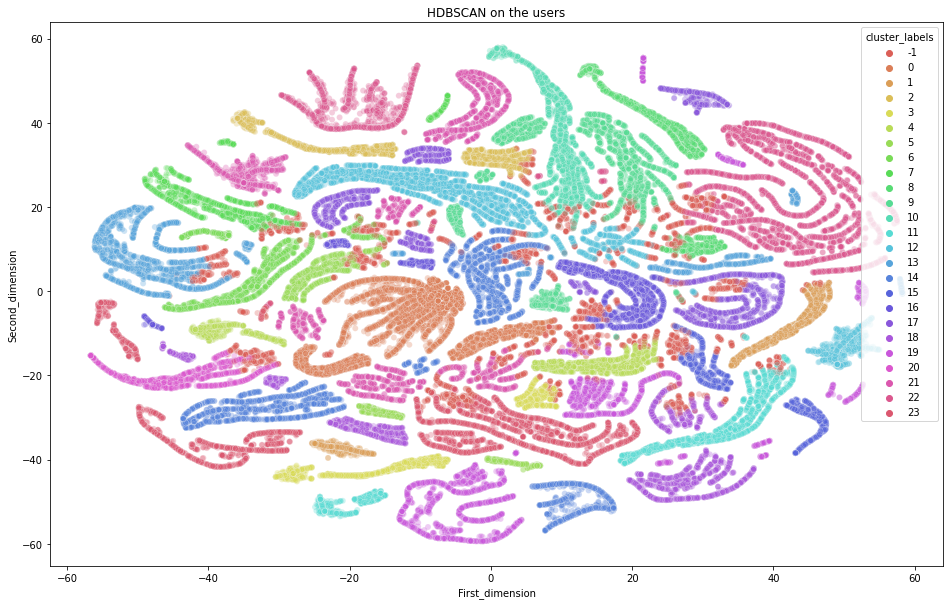

In [203]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters_50,
                                                          tsne_results_50,
                                                          min_cluster_size=500,
                                                          min_samples=30)

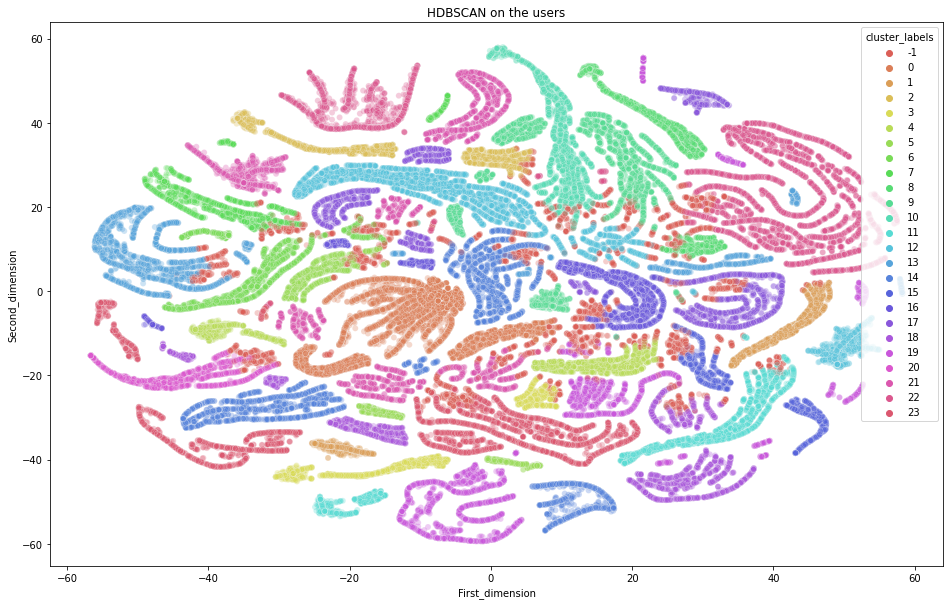

In [204]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters_50,
                                                          tsne_results_50,
                                                          min_cluster_size=700,
                                                          min_samples=30)

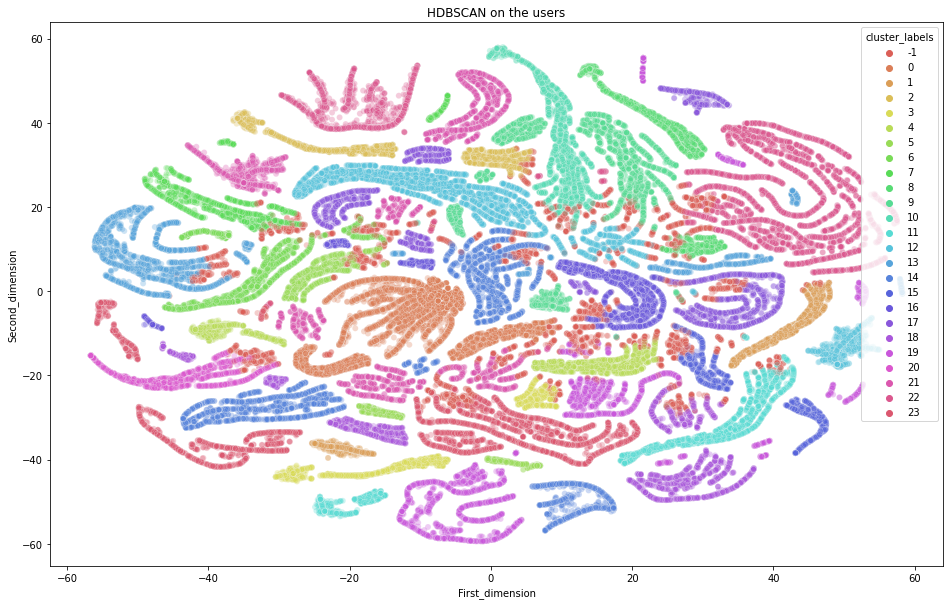

In [205]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters_50,
                                                          tsne_results_50,
                                                          min_cluster_size=1000,
                                                          min_samples=30)

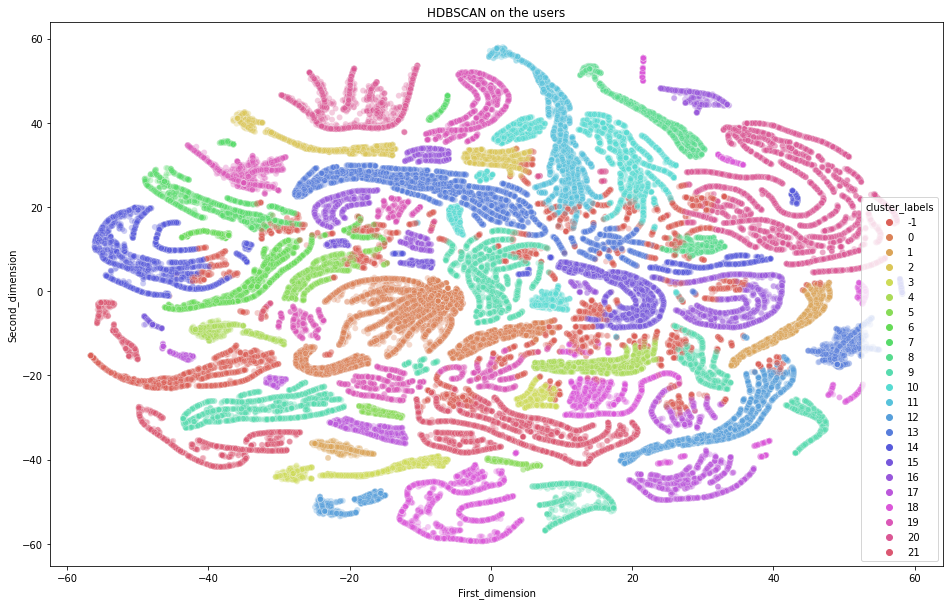

In [213]:
user_model_50, user_labels_50, user_centers_50 = hdbscan_visualize(
    ar_users_clusters_50,
    tsne_results_50,
    min_cluster_size=1500,
    min_samples=30)

# Get Group of artist for each user cluster

In [143]:
col_names_consumption = [
    'user-mboxsha1', 'musicbrainz-artist-id', 'artist-name', 'plays'
]

df = pd.read_csv('../data/usersha1-artmbid-artname-plays.tsv',
                 sep='\t',
                 names=col_names_consumption)

In [149]:
df_artist = df[['musicbrainz-artist-id',
                'artist-name']].groupby('musicbrainz-artist-id',
                                        as_index=False).first()

musicbrainz-artist-id            artist-name
0       00010eb3-ebfe-4965-81ef-0ac64cd49fde  la niña de los peines
1       0001cd84-2a11-4699-8d6b-0abf969c5f06                 midway
2       0002260a-b298-48cc-9895-52c9425796b7          veronica lake
3       00026532-1fe3-45fb-a0df-34aec04a1319         deidre mccalla
4       00026d14-39c6-4f2d-b556-093233b5e714                oblomov
...                                      ...                    ...
160107  fffed9ff-98c6-458a-8379-47e7fb4ba6ec         bbs paranoicos
160108  ffff01cd-0ae0-46c7-867b-d17d8d38cff8         rudolf stember
160109  ffff3742-4ae3-4e13-a29c-d4c164985a5b      die lokalmatadore
160110  ffff44bd-e5a5-4e87-8700-35481264e37d            la sinfonia
160111                       rock / a30a400a         blind the fold

[160112 rows x 2 columns]

In [150]:
artist_id2artist_name = dict(
    zip(df_artist['musicbrainz-artist-id'], df_artist['artist-name']))

In [283]:
def get_user2label(user_labels, id2user):
    
    label2user = {}

    for idx, user in tqdm(id2user.items()):

        user_label = user_labels[idx]

        if user_label in label2user.keys():
            label2user[user_label].append(user)
        else:
            label2user[user_label] = [user]
    
    return label2user

In [284]:
def get_top_artists_per_cluster(user_labels, label2user, matrix_plays, user2id, id2artist, artist_id2artist_name, n_top=10):
    
    for label in set(user_labels):

        # Get the user within the cluster
        user_cluster = label2user[label]
        user_cluster_id = [user2id[user] for user in user_cluster]

        # Get the average number of plays per artist per user within a cluster
        avg_plays = np.squeeze(
            np.asarray(matrix_plays[user_cluster_id].sum(axis=0) /
                       len(user_cluster)))

        # Get the top 10 artists in the cluster
        top_artist_idx = np.argsort(avg_plays)[::-1][:n_top]

        # Get the ID of the cluster
        top_artist = [id2artist[idx] for idx in top_artist_idx]
        avg_plays_top_artist = avg_plays[top_artist_idx]

        top_artist_name = [artist_id2artist_name[artist] for artist in top_artist]

        print('\n### Top artist for cluster {}'.format(label))
        pprint.pprint(dict(zip(top_artist_name, avg_plays_top_artist)))

## dim = 25, td_idf = true

In [214]:
# Mapping user2label

label2user = get_user2label(user_labels, id2user)

100%|██████████| 94407/94407 [00:00<00:00, 440314.40it/s]


In [215]:
get_top_artists_per_cluster(user_labels, label2user, matrix_plays, user2id, id2artist, artist_id2artist_name, n_top=10)


### Top artist for cluster 0
{'belle and sebastian': 22.14385093167702,
 'bob dylan': 28.2183850931677,
 'cat power': 22.269813664596274,
 'coldplay': 21.003850931677018,
 'elliott smith': 16.764844720496896,
 'johnny cash': 16.78385093167702,
 'radiohead': 33.895031055900624,
 'sufjan stevens': 18.044472049689443,
 'the beatles': 43.244596273291926,
 'tom waits': 18.361614906832298}

### Top artist for cluster 1
{'coldplay': 19.572431077694237,
 'green day': 13.117794486215539,
 'michael jackson': 14.756390977443608,
 'nofx': 11.7203007518797,
 'pink floyd': 14.251127819548872,
 'queen': 13.213032581453634,
 'radiohead': 15.213533834586466,
 'red hot chili peppers': 14.023558897243108,
 'the beatles': 27.801002506265664,
 'u2': 15.599498746867168}

### Top artist for cluster 2
{'bob dylan': 22.13302516692347,
 'herbie hancock': 16.368258859784284,
 'john coltrane': 24.8366718027735,
 'led zeppelin': 16.317925012840266,
 'miles davis': 37.66204417051875,
 'pink floyd': 22.287621982537

## dim = 50, td_idf = true

In [216]:
# Mapping user2label

label2user_50 = get_user2label(user_labels_50)

100%|██████████| 94407/94407 [00:00<00:00, 419661.55it/s]


In [217]:
get_top_artists_per_cluster(user_labels_50, label2user_50, matrix_plays, user2id, id2artist, artist_id2artist_name, n_top=10)


### Top artist for cluster 0
{'belle and sebastian': 22.14385093167702,
 'bob dylan': 28.2183850931677,
 'cat power': 22.269813664596274,
 'coldplay': 21.003850931677018,
 'elliott smith': 16.764844720496896,
 'johnny cash': 16.78385093167702,
 'radiohead': 33.895031055900624,
 'sufjan stevens': 18.044472049689443,
 'the beatles': 43.244596273291926,
 'tom waits': 18.361614906832298}

### Top artist for cluster 1
{'coldplay': 19.572431077694237,
 'green day': 13.117794486215539,
 'michael jackson': 14.756390977443608,
 'nofx': 11.7203007518797,
 'pink floyd': 14.251127819548872,
 'queen': 13.213032581453634,
 'radiohead': 15.213533834586466,
 'red hot chili peppers': 14.023558897243108,
 'the beatles': 27.801002506265664,
 'u2': 15.599498746867168}

### Top artist for cluster 2
{'bob dylan': 22.13302516692347,
 'herbie hancock': 16.368258859784284,
 'john coltrane': 24.8366718027735,
 'led zeppelin': 16.317925012840266,
 'miles davis': 37.66204417051875,
 'pink floyd': 22.287621982537

 # Get user demographic information within a same cluster

In [163]:
col_names_user = ['user-mboxsha1', 'gender', 'age', 'country', 'signup']
df_user = pd.read_csv('../data/usersha1-profile.tsv',
                      sep='\t',
                      names=col_names_user)
df_user.head()

user-mboxsha1 gender   age        country  \
0  00000c289a1829a808ac09c00daf10bc3c4e223b      f  22.0        Germany   
1  00001411dc427966b17297bf4d69e7e193135d89      f   NaN         Canada   
2  00004d2ac9316e22dc007ab2243d6fcb239e707d    NaN   NaN        Germany   
3  000063d3fe1cf2ba248b9e3c3f0334845a27a6bf      m  19.0         Mexico   
4  00007a47085b9aab8af55f52ec8846ac479ac4fe      m  28.0  United States   

         signup  
0   Feb 1, 2007  
1   Dec 4, 2007  
2   Sep 1, 2006  
3  Apr 28, 2008  
4  Jan 27, 2006

In [302]:
def get_demographic_data(user_labels):
    
    for label in set(user_labels):

        # Get the user within the cluster
        user_cluster = label2user[label]

        # Get demographic informations about user within a same cluster
        df_user_cluster = df_user[df_user['user-mboxsha1'].isin(set(user_cluster))]

        # Gender
        nb_male = df_user_cluster['gender'].value_counts().loc['m']
        nb_female = df_user_cluster['gender'].value_counts().loc['f']

        # Age
        mean_age = np.mean(df_user_cluster['age'])
        std_age = np.std(df_user_cluster['age'])

        # Country
        top_5_country = df_user_cluster['country'].value_counts()[:5].to_dict()

        print('\n### Demographic informations on cluster {}'.format(label))

        print('Mean age: {}'.format(mean_age))
        print('Std age: {}'.format(std_age))
        print('Proportion of Mens: {:.2f}%'.format(nb_male * 100 /
                                                   (nb_male + nb_female)))
        print('Proportion of Womens: {:.2f}%'.format(nb_female * 100 /
                                                     (nb_male + nb_female)))
    
        print('Top 5 countries: '.format(label))
        pprint.pprint(top_5_country)

## dim = 25, td_idf = true

In [303]:
get_demographic_data(user_labels)


### Demographic informations on cluster 0
Mean age: 27.687612502045493
Std age: 32.28533362863227
Proportion of Mens: 73.02%
Proportion of Womens: 26.98%
Top 5 countries: 
{'Brazil': 866,
 'Germany': 452,
 'Spain': 396,
 'United Kingdom': 777,
 'United States': 2095}

### Demographic informations on cluster 1
Mean age: 27.812215724496426
Std age: 10.714401303175867
Proportion of Mens: 84.64%
Proportion of Womens: 15.36%
Top 5 countries: 
{'Germany': 257,
 'Italy': 78,
 'Sweden': 121,
 'United Kingdom': 160,
 'United States': 499}

### Demographic informations on cluster 2
Mean age: 28.62249283667622
Std age: 53.3541182065863
Proportion of Mens: 84.87%
Proportion of Womens: 15.13%
Top 5 countries: 
{'Germany': 129,
 'Poland': 104,
 'Spain': 90,
 'United Kingdom': 194,
 'United States': 348}

### Demographic informations on cluster 3
Mean age: 25.040856031128406
Std age: 8.331040906607882
Proportion of Mens: 76.19%
Proportion of Womens: 23.81%
Top 5 countries: 
{'Germany': 178,
 'Russia

## dim = 50, td_idf = true

In [304]:
get_demographic_data(user_labels_50)


### Demographic informations on cluster 0
Mean age: 27.687612502045493
Std age: 32.28533362863227
Proportion of Mens: 73.02%
Proportion of Womens: 26.98%
Top 5 countries: 
{'Brazil': 866,
 'Germany': 452,
 'Spain': 396,
 'United Kingdom': 777,
 'United States': 2095}

### Demographic informations on cluster 1
Mean age: 27.812215724496426
Std age: 10.714401303175867
Proportion of Mens: 84.64%
Proportion of Womens: 15.36%
Top 5 countries: 
{'Germany': 257,
 'Italy': 78,
 'Sweden': 121,
 'United Kingdom': 160,
 'United States': 499}

### Demographic informations on cluster 2
Mean age: 28.62249283667622
Std age: 53.3541182065863
Proportion of Mens: 84.87%
Proportion of Womens: 15.13%
Top 5 countries: 
{'Germany': 129,
 'Poland': 104,
 'Spain': 90,
 'United Kingdom': 194,
 'United States': 348}

### Demographic informations on cluster 3
Mean age: 25.040856031128406
Std age: 8.331040906607882
Proportion of Mens: 76.19%
Proportion of Womens: 23.81%
Top 5 countries: 
{'Germany': 178,
 'Russia

# Validation

In [277]:
# Load testing data
matrix_plays_test = scipy.sparse.load_npz('../data/matrix_plays_test.npz').T
id2user_test = load_pickle('../data/id2user_test.pickle')
user2id_test = load_pickle('../data/user2id_test.pickle')

# Compute user mean for test set
user_means_test = compute_user_means(X, matrix_plays_test, id2user_test)
ar_users_clusters_test = build_matrix_clustering(user_means_test, artist_model, artist_centers)

user_test_labels, strengths = hdbscan.approximate_predict(
    user_model, ar_users_clusters_test)

100%|██████████| 10490/10490 [00:05<00:00, 1776.34it/s]
10490it [00:08, 1235.09it/s]


In [285]:
# Mapping label2user_test
label2user_test = get_user2label(user_test_labels, id2user_test)

100%|██████████| 10490/10490 [00:00<00:00, 136004.01it/s]


In [286]:
get_top_artists_per_cluster(user_test_labels, label2user_test, matrix_plays_test, user2id_test, id2artist, artist_id2artist_name)


### Top artist for cluster 0
{'gregorian': 39.166666666666664,
 'jordi savall': 33.333333333333336,
 'man or astro-man?': 37.833333333333336,
 'matthew dear': 34.833333333333336,
 'mf doom': 44.916666666666664,
 'mike oldfield': 30.916666666666668,
 'moby': 53.416666666666664,
 'ned doheny': 37.0,
 'novaspace': 80.66666666666667,
 'the gaslamp killer': 43.666666666666664}

### Top artist for cluster 2
{'armin van buuren': 148.94594594594594,
 'atb': 253.27027027027026,
 'cascada': 141.21621621621622,
 'e-type': 327.5405405405405,
 'groove coverage': 174.7027027027027,
 'sandra': 186.7027027027027,
 'schiller': 197.97297297297297,
 'scooter': 156.8918918918919,
 'sylver': 171.59459459459458,
 'tiësto': 122.64864864864865}

### Top artist for cluster 3
{'annihilator': 107.14285714285714,
 'black sabbath': 87.33928571428571,
 'iron maiden': 72.39285714285714,
 'judas priest': 76.44642857142857,
 'king diamond': 130.25,
 'megadeth': 86.41071428571429,
 'mercyful fate': 71.85714285714286,
